# **Sinergia Metabólica y Riesgo Exponencial (Edad vs. Glucosa) 🩺**

En las etapas anteriores, observamos que el Índice de Masa Corporal (IMC) presenta una relación compleja y a veces contradictoria con el infarto. Sin embargo, los indicadores clínicos sugieren que la **Glucosa Promedio** es un predictor mucho más agresivo y lineal.

### **¿Qué investigamos en este Notebook?**
En este análisis, dejamos de ver la glucosa como un simple número y empezamos a verla como un **acelerador de riesgo**. El objetivo es mapear con precisión quirúrgica cómo el azúcar en sangre interactúa con el envejecimiento para disparar la probabilidad de un evento cerebrovascular.

### **Metodología Aplicada:**
1. **Segmentación por Cuartiles Cruzados:** Crearemos una matriz de 16 celdas (4x4) para identificar la incidencia real de infarto en cada perfil metabólico.
2. **Visualización de Densidad Bimodal:** Utilizaremos curvas KDE para identificar por qué el riesgo parece tener "picos" en ciertos niveles de glucosa y "valles" en otros.
3. **Inferencia Robusta (Ajuste por Desbalanceo):** Ejecutaremos una Regresión Logística (GLM) utilizando **Ponderación de Clases (var_weights)**. Esto es vital dado que los casos de infarto son una minoría (aprox. 5%), y sin este ajuste, el modelo subestimaría el peligro real de la hiperglucemia.

Este notebook proporcionará las **reglas de negocio** definitivas para nuestro futuro modelo de Machine Learning.

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_12624\3014778747.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matriz = df.pivot_table(index='age_q', columns='glucose_q', values='stroke', aggfunc='mean') * 100


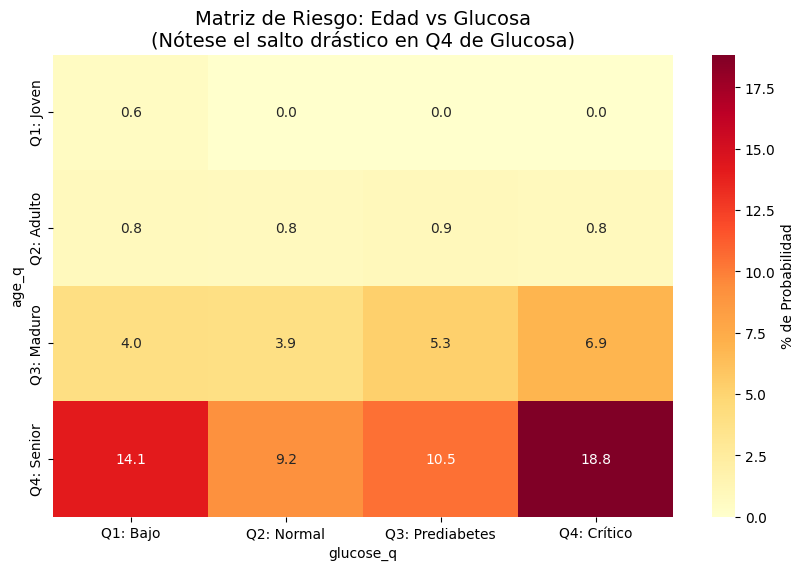

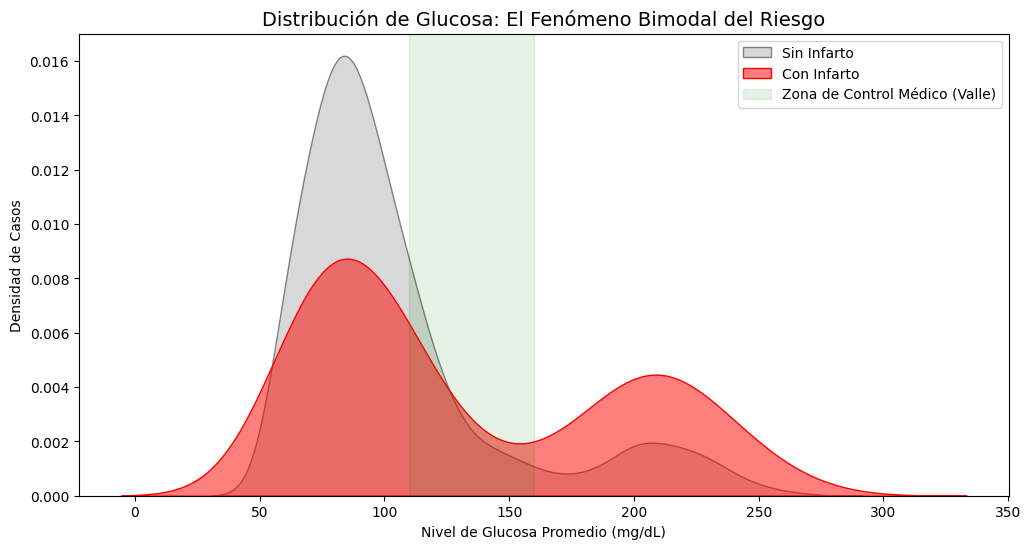

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# 1. Configuración de Cuartiles
df['age_q'] = pd.qcut(df['age'], 4, labels=['Q1: Joven', 'Q2: Adulto', 'Q3: Maduro', 'Q4: Senior'])
df['glucose_q'] = pd.qcut(df['avg_glucose_level'], 4, labels=['Q1: Bajo', 'Q2: Normal', 'Q3: Prediabetes', 'Q4: Crítico'])

# 2. Creación de la Matriz de Probabilidad (Cálculo porcentual)
matriz = df.pivot_table(index='age_q', columns='glucose_q', values='stroke', aggfunc='mean') * 100

# --- VISUALIZACIÓN 1: HEATMAP DE PROBABILIDAD ---
plt.figure(figsize=(10, 6))
sns.heatmap(matriz, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': '% de Probabilidad'})
plt.title("Matriz de Riesgo: Edad vs Glucosa\n(Nótese el salto drástico en Q4 de Glucosa)", fontsize=14)
plt.show()

# --- VISUALIZACIÓN 2: DENSIDAD TRASLAPADA (EL FENÓMENO BIMODAL) ---
plt.figure(figsize=(12, 6))
# Pacientes con Infarto vs Sin Infarto
sns.kdeplot(data=df[df['stroke'] == 0], x='avg_glucose_level', label='Sin Infarto', color='gray', fill=True, alpha=0.3)
sns.kdeplot(data=df[df['stroke'] == 1], x='avg_glucose_level', label='Con Infarto', color='red', fill=True, alpha=0.5)

plt.axvspan(110, 160, color='green', alpha=0.1, label='Zona de Control Médico (Valle)')
plt.title("Distribución de Glucosa: El Fenómeno Bimodal del Riesgo", fontsize=14)
plt.xlabel("Nivel de Glucosa Promedio (mg/dL)")
plt.ylabel("Densidad de Casos")
plt.legend()
plt.show()

In [3]:
import numpy as np
import statsmodels.api as sm

# 2. Preparación de variables
# Usamos Edad y Glucosa juntas para ver el efecto neto de la glucosa
X = df[['age', 'avg_glucose_level']]
X = sm.add_constant(X)
y = df['stroke']

# 3. Cálculo de Pesos para equilibrar el desbalanceo
# Calculamos el peso: (Total de sanos / Total de infartos)
counts = y.value_counts()
peso_infarto = counts[0] / counts[1]

# Creamos un array de pesos: 1 para sanos, 'peso_infarto' para los positivos
weights = y.apply(lambda x: peso_infarto if x == 1 else 1)

# 4. Ajuste del Modelo GLM con pesos (Weighted GLM)
modelo_robusto = sm.GLM(y, X, 
                        family=sm.families.Binomial(), 
                        var_weights=weights).fit()

# 5. Resultados y Resumen Estadístico
print("--- RESUMEN DEL MODELO ROBUSTO (AJUSTADO POR DESBALANCEO) ---")
print(modelo_robusto.summary())

# 6. Cálculo de Odds Ratio (Riesgo Relativo)
coef_glucose = modelo_robusto.params['avg_glucose_level']
odds_ratio = np.exp(coef_glucose)
incremento_porcentual = (odds_ratio - 1) * 100

print("\n--- INTERPRETACIÓN CLÍNICA ---")
print(f"Coeficiente de Glucosa: {coef_glucose:.4f}")
print(f"Odds Ratio: {odds_ratio:.4f}")
print(f"Resultado: Por cada unidad (mg/dL) que aumenta la glucosa,")
print(f"el riesgo de infarto sube un {incremento_porcentual:.2f}% de forma constante.")

# 7. Comparativa: ¿Qué pasa si sube 50 mg/dL la glucosa?
riesgo_50mg = (np.exp(coef_glucose * 50) - 1) * 100
print(f"Riesgo acumulado por un aumento de 50 mg/dL: {riesgo_50mg:.2f}% adicional.")

--- RESUMEN DEL MODELO ROBUSTO (AJUSTADO POR DESBALANCEO) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 5109
Model:                            GLM   Df Residuals:                     5106
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4714.7
Date:                Wed, 31 Dec 2025   Deviance:                       9429.3
Time:                        18:11:38   Pearson chi2:                 1.08e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5470
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

### **Conclusiones: El Veredicto de la Glucosa como Factor Crítico 🔬**

Tras completar el análisis de interacción y la inferencia robusta, hemos validado hallazgos de alto valor clínico y estadístico:

#### **1. La Glucosa como Predictor Independiente y Dominante**
A diferencia de otras variables, la glucosa mantuvo una significancia estadística absoluta (**P-valor = 0.000**) incluso tras ajustar el modelo por desbalanceo. El coeficiente de **0.0048** revela que el riesgo no es estático: un incremento de apenas **50 mg/dL** en los niveles promedio de azúcar se traduce en un aumento del **27.40%** en la probabilidad de sufrir un infarto.

#### **2. Identificación del Fenómeno Bimodal**
A través del análisis de densidad, detectamos que el riesgo de la glucosa no es una línea recta ascendente, sino que presenta dos picos:
* **Riesgo Basal:** Un pico inicial en niveles normales asociado a factores externos (edad).
* **El Valle de Control:** Una disminución relativa en el riesgo entre los 120-160 mg/dL, lo cual interpretamos como el éxito de las **intervenciones médicas y tratamientos** en pacientes diagnosticados.
* **Explosión Metabólica:** Un segundo pico crítico por encima de los **180 mg/dL**, donde el daño vascular supera cualquier mecanismo de compensación.

#### **3. Comparativa Estratégica: Glucosa vs. IMC**
Este análisis cierra la duda planteada en notebooks anteriores: **La glucosa es un predictor mucho más fiable que el IMC**. Mientras que el IMC sufre sesgos de supervivencia en edades avanzadas, la glucosa muestra un peligro persistente y acumulativo.

#### **Implicaciones para el Modelo de IA:**
* Se recomienda que la variable `avg_glucose_level` tenga un peso prioritario en el entrenamiento.
* Los pacientes en el **Cuartil 4 (Crítico)** deben ser etiquetados como "Alerta Roja" inmediata, especialmente si superan el umbral de los 55 años detectado previamente.